<a href="https://colab.research.google.com/github/JoseAlbertoSeco/BlablacarCarpooling_DataMining/blob/Patterns/notebooks/Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn import neighbors
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error
from sklearn import metrics
from sklearn import linear_model
from sklearn import tree 

# Carga de datos

In [2]:
#!wget https://github.com/JoseAlbertoSeco/MineriaDatos/raw/main/data/processed/df_CLM.csv
#!wget https://github.com/JoseAlbertoSeco/MineriaDatos/raw/main/data/processed/df_Andalucia.csv

## Carga provincial

In [3]:
andalucia = pd.read_csv("df_andalucia.csv") 
andalucia = andalucia.drop(andalucia.columns[[0]], axis=1)
andalucia.head(3)

,DIA,AÑO,SEMANA,MES,PAIS,ORIGEN,DESTINO,ASIENTOS_OFERTADOS,ASIENTOS_CONFIRMADOS,VIAJES_OFERTADOS,VIAJES_CONFIRMADOS,OFERTANTES,OFERTANTES_NUEVOS,CA_ORIGEN,CA_DESTINO,PROVINCIA_ORIGEN,PROVINCIA_DESTINO,INTERPROVINCIAL,Festivo
0,2017-11-01,2017,44,11,es,Albox,Granada,1.0,1,1,1,1,0,Andalucía,Andalucía,Almería,Granada,No,Si
1,2017-11-03,2017,44,11,es,Albox,Granada,12.0,1,4,1,4,0,Andalucía,Andalucía,Almería,Granada,No,No
2,2017-11-05,2017,44,11,es,Albox,Granada,2.0,1,1,1,1,0,Andalucía,Andalucía,Almería,Granada,No,No


In [4]:
clm = pd.read_csv("df_castilla.csv") 
clm = clm.drop(clm.columns[[0]], axis=1)
clm.head(3)

,DIA,AÑO,SEMANA,MES,PAIS,ORIGEN,DESTINO,ASIENTOS_OFERTADOS,ASIENTOS_CONFIRMADOS,VIAJES_OFERTADOS,VIAJES_CONFIRMADOS,OFERTANTES,OFERTANTES_NUEVOS,CA_ORIGEN,CA_DESTINO,PROVINCIA_ORIGEN,PROVINCIA_DESTINO,INTERPROVINCIAL,Festivo
0,2017-11-05,2017,44,11,es,Albacete,Guadalajara,11.0,1,6,1,6,1,Castilla-La Mancha,Castilla-La Mancha,Albacete,Guadalajara,No,No
1,2017-11-12,2017,45,11,es,Albacete,Guadalajara,11.0,1,6,1,6,1,Castilla-La Mancha,Castilla-La Mancha,Albacete,Guadalajara,No,No
2,2017-11-19,2017,46,11,es,Albacete,Guadalajara,8.0,1,6,1,6,0,Castilla-La Mancha,Castilla-La Mancha,Albacete,Guadalajara,No,No


# Label Encoding

Transformamos categorias categóricas en categorias numéricas

## Encoding Andalucia

In [5]:
andalucia.dtypes

DIA                      object
AÑO                       int64
SEMANA                    int64
MES                       int64
PAIS                     object
ORIGEN                   object
DESTINO                  object
ASIENTOS_OFERTADOS      float64
ASIENTOS_CONFIRMADOS      int64
VIAJES_OFERTADOS          int64
VIAJES_CONFIRMADOS        int64
OFERTANTES                int64
OFERTANTES_NUEVOS         int64
CA_ORIGEN                object
CA_DESTINO               object
PROVINCIA_ORIGEN         object
PROVINCIA_DESTINO        object
INTERPROVINCIAL          object
Festivo                  object
dtype: object

In [6]:
andalucia_to_encoded = andalucia.copy()

In [7]:
# 'ORIGEN', 'DESTINO', 'CA_ORIGEN', 'CA_DESTINO', 'PROVINCIA_ORIGEN', 'PROVINCIA_DESTINO', 'INTERPROVINCIAL'
andalucia_to_encoded['ORIGEN_LE'] = andalucia['ORIGEN'].astype('category').cat.codes

In [8]:
andalucia_to_encoded['DESTINO_LE'] = andalucia['DESTINO'].astype('category').cat.codes

In [9]:
andalucia_to_encoded['PROVINCIA_ORIGEN_LE'] = andalucia['PROVINCIA_ORIGEN'].astype('category').cat.codes

In [10]:
andalucia_to_encoded['PROVINCIA_DESTINO_LE'] = andalucia['PROVINCIA_DESTINO'].astype('category').cat.codes

In [11]:
andalucia_to_encoded['INTERPROVINCIAL_LE'] = andalucia['INTERPROVINCIAL'].astype('category').cat.codes

In [12]:
andalucia_to_encoded['FESTIVOS_LE'] = andalucia['Festivo'].astype('category').cat.codes

In [13]:
andalucia_to_encoded['DIA'] =  pd.to_datetime(andalucia['DIA'], format='%Y-%m-%d')

In [14]:
andalucia_to_encoded.tail(5)

,DIA,AÑO,SEMANA,MES,PAIS,ORIGEN,DESTINO,ASIENTOS_OFERTADOS,ASIENTOS_CONFIRMADOS,VIAJES_OFERTADOS,VIAJES_CONFIRMADOS,OFERTANTES,OFERTANTES_NUEVOS,CA_ORIGEN,CA_DESTINO,PROVINCIA_ORIGEN,PROVINCIA_DESTINO,INTERPROVINCIAL,Festivo,ORIGEN_LE,DESTINO_LE,PROVINCIA_ORIGEN_LE,PROVINCIA_DESTINO_LE,INTERPROVINCIAL_LE,FESTIVOS_LE
246050,2019-10-31,2019,44,10,es,Sevilla,Pruna,8.0,1,2,1,1,0,Andalucía,Andalucía,Sevilla,Sevilla,Si,No,418,392,8,8,1,0
246051,2019-10-18,2019,42,10,es,Sevilla,Linares de la Sierra,3.0,3,1,1,1,0,Andalucía,Andalucía,Sevilla,Huelva,No,No,418,299,8,4,0,0
246052,2018-08-03,2018,31,8,es,Chipiona,Tocina,3.0,2,1,1,1,0,Andalucía,Andalucía,Cádiz,Sevilla,No,No,123,449,1,8,0,0
246053,2018-06-08,2018,23,6,es,Mairena del Aljarafe,Corteconcepción,3.0,2,1,1,1,1,Andalucía,Andalucía,Sevilla,Huelva,No,No,296,142,8,4,0,0
246054,2018-07-06,2018,27,7,es,Tomares,Algámitas,4.0,1,1,1,1,0,Andalucía,Andalucía,Sevilla,Sevilla,Si,No,428,25,8,8,1,0


In [15]:
andalucia_encoded = andalucia_to_encoded.drop(columns=['ORIGEN', 'DESTINO', 'CA_ORIGEN', 'CA_DESTINO', 'PROVINCIA_ORIGEN', 'PROVINCIA_DESTINO', 'INTERPROVINCIAL', 'Festivo','PAIS'])
andalucia_encoded.head(2)

,DIA,AÑO,SEMANA,MES,ASIENTOS_OFERTADOS,ASIENTOS_CONFIRMADOS,VIAJES_OFERTADOS,VIAJES_CONFIRMADOS,OFERTANTES,OFERTANTES_NUEVOS,ORIGEN_LE,DESTINO_LE,PROVINCIA_ORIGEN_LE,PROVINCIA_DESTINO_LE,INTERPROVINCIAL_LE,FESTIVOS_LE
0,2017-11-01,2017,44,11,1.0,1,1,1,1,0,6,218,0,3,0,1
1,2017-11-03,2017,44,11,12.0,1,4,1,4,0,6,218,0,3,0,0


## Encoding Castilla-La Mancha

In [16]:
clm_to_encode = clm.copy()

In [17]:
# 'ORIGEN', 'DESTINO', 'CA_ORIGEN', 'CA_DESTINO', 'PROVINCIA_ORIGEN', 'PROVINCIA_DESTINO', 'INTERPROVINCIAL'
clm_to_encode['ORIGEN_LE'] = clm['ORIGEN'].astype('category').cat.codes

In [18]:
clm_to_encode['DESTINO_LE'] = clm['DESTINO'].astype('category').cat.codes

In [19]:
clm_to_encode['PROVINCIA_ORIGEN_LE'] = clm['PROVINCIA_ORIGEN'].astype('category').cat.codes

In [20]:
clm_to_encode['PROVINCIA_DESTINO_LE'] = clm['PROVINCIA_DESTINO'].astype('category').cat.codes

In [21]:
clm_to_encode['INTERPROVINCIAL_LE'] = clm['INTERPROVINCIAL'].astype('category').cat.codes

In [22]:
clm_to_encode['FESTIVO_LE'] = clm_to_encode['Festivo'].astype('category').cat.codes

In [23]:
clm_to_encode.tail(5)

,DIA,AÑO,SEMANA,MES,PAIS,ORIGEN,DESTINO,ASIENTOS_OFERTADOS,ASIENTOS_CONFIRMADOS,VIAJES_OFERTADOS,VIAJES_CONFIRMADOS,OFERTANTES,OFERTANTES_NUEVOS,CA_ORIGEN,CA_DESTINO,PROVINCIA_ORIGEN,PROVINCIA_DESTINO,INTERPROVINCIAL,Festivo,ORIGEN_LE,DESTINO_LE,PROVINCIA_ORIGEN_LE,PROVINCIA_DESTINO_LE,INTERPROVINCIAL_LE,FESTIVO_LE
20857,2018-01-26,2018,4,1,es,Toledo,Casas de Benítez,3.0,1,1,1,1,0,Castilla-La Mancha,Castilla-La Mancha,Toledo,Cuenca,No,No,117,34,5,3,0,0
20858,2019-10-11,2019,41,10,es,Toledo,La Villa de Don Fadrique,3.0,1,1,1,1,0,Castilla-La Mancha,Castilla-La Mancha,Toledo,Toledo,Si,No,117,76,5,5,1,0
20859,2019-09-06,2019,36,9,es,Valdepeñas,Albatana,3.0,1,1,1,1,0,Castilla-La Mancha,Castilla-La Mancha,Ciudad Real,Albacete,No,No,122,3,1,0,0,0
20860,2018-07-14,2018,28,7,es,Guadalajara,Valdelcubo,3.0,1,1,1,1,0,Castilla-La Mancha,Castilla-La Mancha,Guadalajara,Guadalajara,Si,No,52,139,4,4,1,0
20861,2018-08-10,2018,32,8,es,Guadalajara,Cobeta,5.0,1,2,1,1,0,Castilla-La Mancha,Castilla-La Mancha,Guadalajara,Guadalajara,Si,No,52,44,4,4,1,0


In [24]:
clm_encoded = clm_to_encode.drop(columns=['ORIGEN', 'DESTINO', 'CA_ORIGEN', 'CA_DESTINO', 'PROVINCIA_ORIGEN', 'PROVINCIA_DESTINO', 'INTERPROVINCIAL', 'PAIS', 'Festivo'])
clm_encoded.head(2)

,DIA,AÑO,SEMANA,MES,ASIENTOS_OFERTADOS,ASIENTOS_CONFIRMADOS,VIAJES_OFERTADOS,VIAJES_CONFIRMADOS,OFERTANTES,OFERTANTES_NUEVOS,ORIGEN_LE,DESTINO_LE,PROVINCIA_ORIGEN_LE,PROVINCIA_DESTINO_LE,INTERPROVINCIAL_LE,FESTIVO_LE
0,2017-11-05,2017,44,11,11.0,1,6,1,6,1,1,62,0,4,0,0
1,2017-11-12,2017,45,11,11.0,1,6,1,6,1,1,62,0,4,0,0


# Regression

El proceso de regresión se realizará con los datos de **clm_encoded** y **andalucia_encoded**.

## Feature Selection

In [25]:
def correlation_pearson(df):
  corr_matrix = df.corr(method='pearson')
  return corr_matrix

In [26]:
def graph_correlation(matrix):
  fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 15))

  sns.heatmap(
    matrix,
    annot     = True,
    cbar      = False,
    annot_kws = {"size": 9},
    vmin      = -1,
    vmax      = 1,
    center    = 0,
    cmap      = sns.diverging_palette(20, 220, n=200),
    square    = True,
    ax        = ax
  )

  ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation = 45,
    horizontalalignment = 'right',
  )

  ax.tick_params(labelsize = 10)

In [27]:
andalucia_encoded.dtypes

DIA                     datetime64[ns]
AÑO                              int64
SEMANA                           int64
MES                              int64
ASIENTOS_OFERTADOS             float64
ASIENTOS_CONFIRMADOS             int64
VIAJES_OFERTADOS                 int64
VIAJES_CONFIRMADOS               int64
OFERTANTES                       int64
OFERTANTES_NUEVOS                int64
ORIGEN_LE                        int16
DESTINO_LE                       int16
PROVINCIA_ORIGEN_LE               int8
PROVINCIA_DESTINO_LE              int8
INTERPROVINCIAL_LE                int8
FESTIVOS_LE                       int8
dtype: object

In [28]:
andalucia_features_selectec = andalucia_encoded[['DESTINO_LE','ORIGEN_LE','PROVINCIA_ORIGEN_LE','PROVINCIA_DESTINO_LE','INTERPROVINCIAL_LE','FESTIVOS_LE','DIA','SEMANA','MES', 'VIAJES_CONFIRMADOS']]
andalucia_features_selectec.tail(2)

,DESTINO_LE,ORIGEN_LE,PROVINCIA_ORIGEN_LE,PROVINCIA_DESTINO_LE,INTERPROVINCIAL_LE,FESTIVOS_LE,DIA,SEMANA,MES,VIAJES_CONFIRMADOS
246053,142,296,8,4,0,0,2018-06-08,23,6,1
246054,25,428,8,8,1,0,2018-07-06,27,7,1


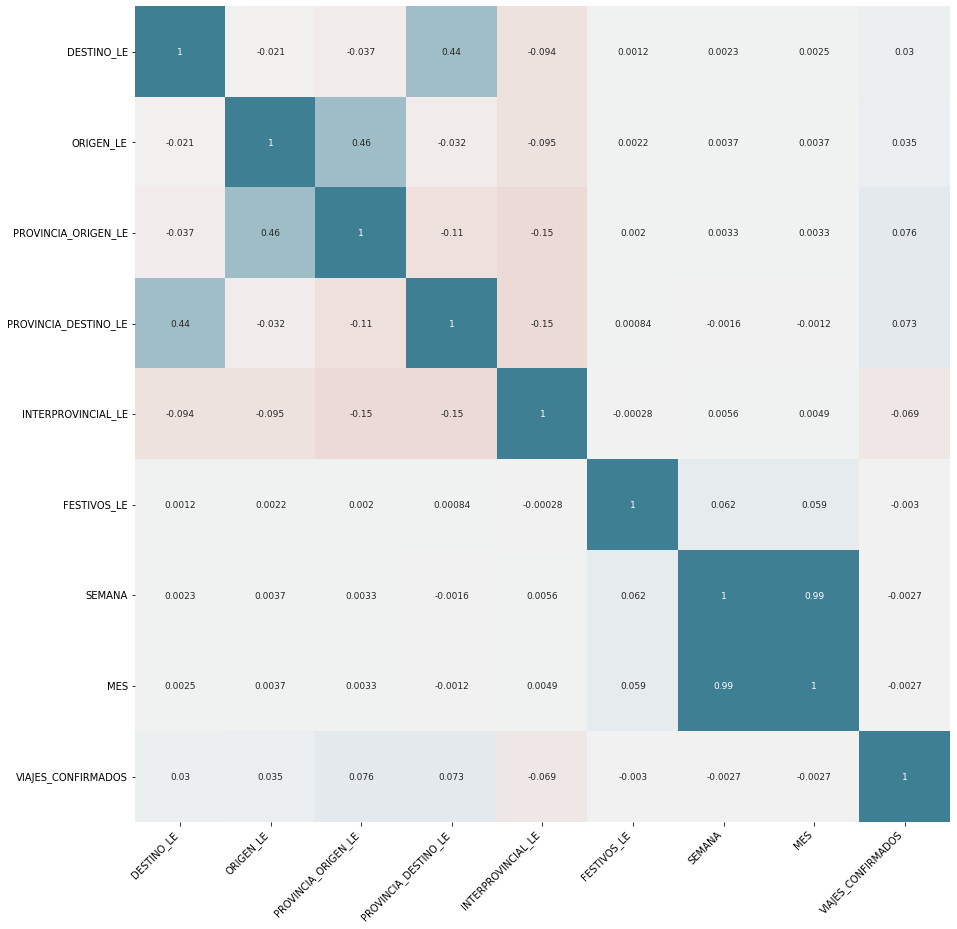

In [29]:
andalucia_corr = correlation_pearson(andalucia_features_selectec)
graph_correlation(andalucia_corr)

In [30]:
clm_features_selectec = clm_encoded[['DESTINO_LE','ORIGEN_LE', 'PROVINCIA_ORIGEN_LE','PROVINCIA_DESTINO_LE','INTERPROVINCIAL_LE','FESTIVO_LE','DIA','SEMANA','MES',   'VIAJES_CONFIRMADOS']]
clm_features_selectec.tail(2)

,DESTINO_LE,ORIGEN_LE,PROVINCIA_ORIGEN_LE,PROVINCIA_DESTINO_LE,INTERPROVINCIAL_LE,FESTIVO_LE,DIA,SEMANA,MES,VIAJES_CONFIRMADOS
20860,139,52,4,4,1,0,2018-07-14,28,7,1
20861,44,52,4,4,1,0,2018-08-10,32,8,1


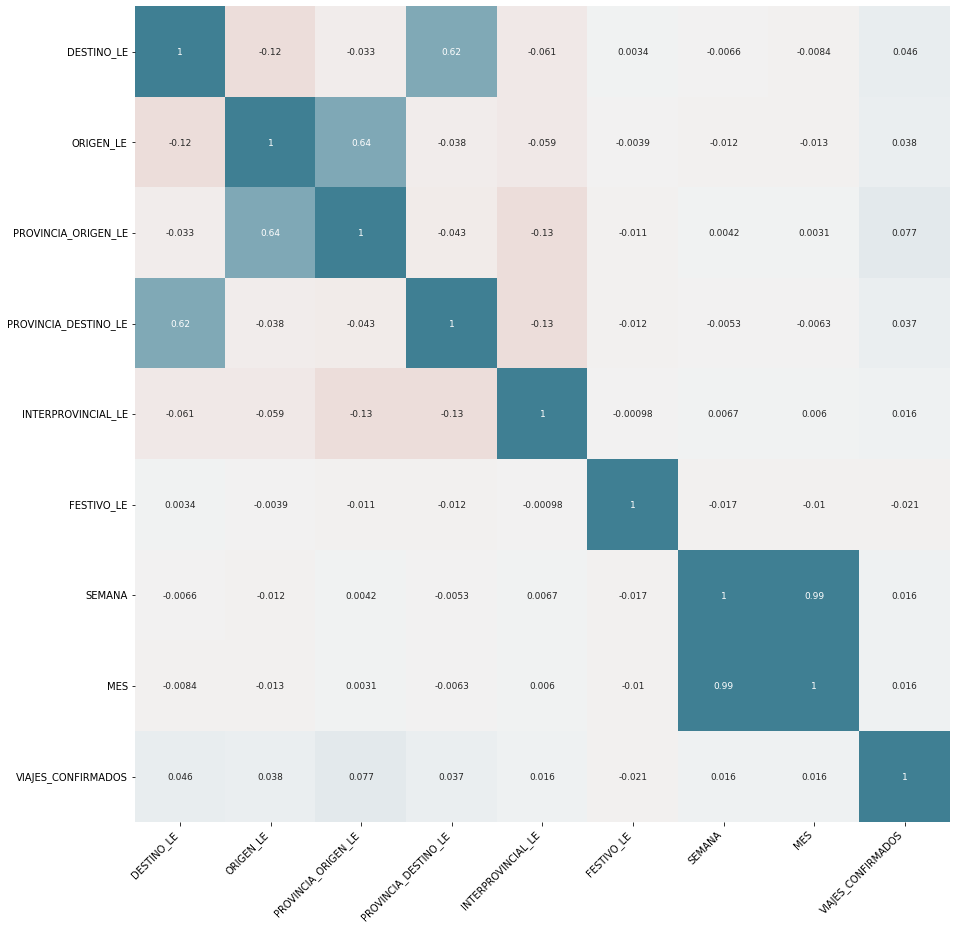

In [31]:
clm_corr = correlation_pearson(clm_features_selectec)
graph_correlation(clm_corr)

OFERTANTES_NUEVOS, ASIENTOS_OFERTADOS, ASIENTOS_CONFIRMADOS, VIAJES_OFERTADOS, OFERTANTES

In [32]:
features_selected = ['OFERTANTES_NUEVOS', 'ASIENTOS_OFERTADOS', 'ASIENTOS_CONFIRMADOS', 'VIAJES_OFERTADOS', 'OFERTANTES']

**Andalucia**

In [33]:
date_index =andalucia_features_selectec.sort_values(by='DIA') 
date_index = date_index.set_index('DIA')

train_andalucia = date_index.loc['2017-11-01':'2018-12-25']
test_andalucia = date_index.loc['2019-01-01':]

X_train_andalucia = train_andalucia.drop(['VIAJES_CONFIRMADOS'],axis=1)
X_test_andalucia = test_andalucia.drop(['VIAJES_CONFIRMADOS'],axis=1)
y_train_andalucia = train_andalucia['VIAJES_CONFIRMADOS']
y_test_andalucia = test_andalucia['VIAJES_CONFIRMADOS']


X_train_andalucia.reset_index(drop = True, inplace = True)

**Castilla-La Mancha**

In [34]:

date_index =clm_features_selectec.sort_values(by='DIA') 
date_index = date_index.set_index('DIA')

train_clm = date_index.loc['2017-11-01':'2018-12-28']
test_clm = date_index.loc['2019-01-01':]

X_train_clm = train_clm.drop(['VIAJES_CONFIRMADOS'],axis=1)
X_test_clm = test_clm.drop(['VIAJES_CONFIRMADOS'],axis=1)
y_train_clm = train_clm['VIAJES_CONFIRMADOS']
y_test_clm = test_clm['VIAJES_CONFIRMADOS']

X_train_clm.reset_index(drop = True, inplace = True)

In [35]:
X_train_clm

,DESTINO_LE,ORIGEN_LE,PROVINCIA_ORIGEN_LE,PROVINCIA_DESTINO_LE,INTERPROVINCIAL_LE,FESTIVO_LE,SEMANA,MES
0,1,118,1,0,0,1,44,11
1,153,1,0,0,1,1,44,11
2,153,37,1,0,0,1,44,11
3,134,1,0,5,0,1,44,11
4,135,117,5,1,0,1,44,11
...,...,...,...,...,...,...,...,...
11457,42,1,0,1,0,1,52,12
11458,1,37,1,0,0,1,52,12
11459,42,69,5,1,0,1,52,12
11460,135,117,5,1,0,1,52,12


## KNN

In [36]:
def neigh_classi(cv, iterations,X_train, y_train, metric = 'minkowski'):
  score = []
  for i, weights in enumerate(['uniform', 'distance']):
    total_scores = []
    for n_neighbors in range(1,iterations):
      fold_accuracy = []
      knn = neighbors.KNeighborsRegressor(n_neighbors, weights=weights, metric='euclidean')
       # verificar cada uno de los modelos con validación cruzada.
      for train_fold, test_fold in cv.split(X_train):
          # División train test aleatoria
          # train
        fx_train = X_train.iloc[train_fold]
        fy_train = y_train.iloc[train_fold]
          # test
        fx_test = X_train.iloc[test_fold]
        fy_test = y_train.iloc[test_fold]

          # entrenamiento y ejecución del modelo
        knn.fit( X = fx_train, y = fy_train)
        y_pred = knn.predict(X = fx_test)
          # evaluación del modelo
        mae = mean_absolute_error(fy_test, y_pred)
        fold_accuracy.append(mae)
      total_scores.append(sum(fold_accuracy)/len(fold_accuracy))
   
    plt.plot(range(1,len(total_scores)+1), total_scores, 
             marker='o', label=weights)
    print('Min Value ' +  weights + " : " +  str(min(total_scores)) +" (" + str(np.argmin(total_scores) + 1) + ")")
    plt.ylabel('MAE')
    score.append(np.argmin(total_scores) + 1)


  plt.legend()
  plt.show()
  return score


In [37]:
cv = KFold(n_splits = 5, shuffle = False) # shuffle == false cause we have temporal variable

**Andalucía**


Min Value uniform : 1.6116815412502414 (5)
Min Value distance : 1.6128271964924494 (6)


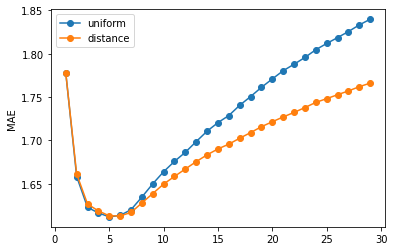

In [38]:
neigh_m_andalucia = neigh_classi(cv, 30,X_train_andalucia, y_train_andalucia,'manhattan')

**Castilla-La Mancha**

Min Value uniform : 0.7437260029467591 (7)
Min Value distance : 0.744933466287985 (5)


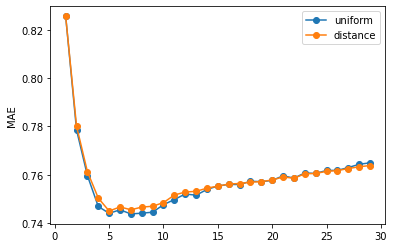

In [39]:
neigh_m_clm = neigh_classi(cv, 30, X_train_clm, y_train_clm,'manhattan')

## Predicción

In [40]:
from sklearn import metrics

In [41]:
def prediction(n, X_train, y_test):
  # constructor
  n_neighbors = n
  weights = 'uniform'

  knn = neighbors.KNeighborsRegressor(n_neighbors= n_neighbors, weights=weights, metric = 'manhattan') 

  # fit and predict
  knn.fit( X = X_train_clm, y = y_train_clm)
  y_pred = knn.predict(X = X_test_clm)

  print ("MAE:", metrics.mean_absolute_error(y_pred , y_test_clm))
  print ("MAPE:", metrics.mean_absolute_percentage_error(y_pred , y_test_clm))
  print ("MSE:", metrics.mean_squared_error(y_pred , y_test_clm))
  print ("R^2:", metrics.r2_score(y_pred , y_test_clm))

  xx = np.stack(i for i in range(y_test_clm.shape[0]))
  plt.plot(xx, y_test_clm, c='r', label='data')

  plt.plot(xx, y_pred, c='g', label='prediction')
  plt.axis('tight')
  plt.legend()
  plt.title("KNeighborsRegressor (k = %i, weights = '%s')" % (n_neighbors,
                                                                weights))

  plt.show()
  return y_pred

MAE: 0.7653498043052838
MAPE: 0.42612823959345875
MSE: 1.670490285155158
R^2: -3.2025118795808067


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


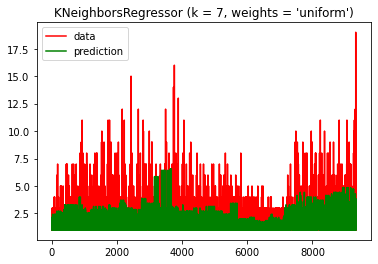

In [42]:
model_andalucia = prediction(neigh_m_clm[0], X_train_clm, y_test_clm)

MAE: 0.767679794520548
MAPE: 0.4310450731169634
MSE: 1.7265924657534246
R^2: -2.711935510822119


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


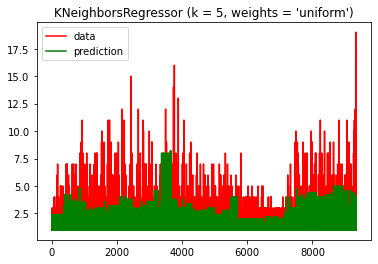

In [43]:
model_clm = prediction(neigh_m_andalucia[0], X_train_andalucia, y_test_andalucia)

# Arboles de decision

In [44]:
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error

cv = KFold(n_splits = 10, shuffle = True)
def get_depth(X_train, y_train):
  total_scores = []
  for i in range(1,30):
    fold_mae = []
    regr = tree.DecisionTreeRegressor(max_depth=i)
    for train_fold, test_fold in cv.split(X_train):
      # División train test aleatoria
      # train
      fx_train = X_train.iloc[train_fold]
      fy_train = y_train.iloc[train_fold]
      # test
      fx_test = X_train.iloc[test_fold]
      fy_test = y_train.iloc[test_fold]

      # entrenamiento y ejecución del modelo
      regr.fit(fx_train, fy_train)
      y_pred = regr.predict(fx_test)
      # evaluación del modelo
      mae = mean_absolute_error(fy_test, y_pred)
      fold_mae.append(mae)
    total_scores.append(sum(fold_mae)/len(fold_mae))
      
  depth = np.argmin(total_scores) + 1
  plt.plot(range(1,len(total_scores)+1), total_scores, 
           marker='o')
  print ('Min Value : ' +  str(min(total_scores)) +" (" + str(np.argmin(total_scores) + 1) + ")")
  plt.ylabel('MAE')
  plt.show()
  return depth, y_pred

**Andalucía**

Min Value : 1.3279582416731013 (16)


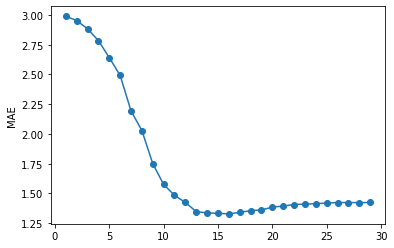

In [45]:
andalucia_depth, y_pred_andalucia = get_depth(X_train_andalucia, y_train_andalucia)

**Castilla-La Mancha**

Min Value : 0.6811197724904288 (7)


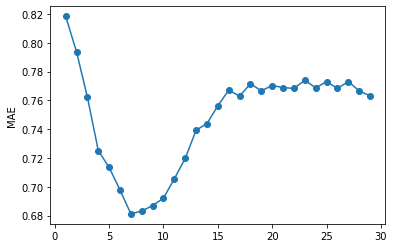

In [46]:
clm_depth, y_pred = get_depth(X_train_clm, y_train_clm)

## Predicción

In [50]:
from sklearn import tree

def decision_tree(X_train, y_train, depth):

  regr = tree.DecisionTreeRegressor(max_depth = depth)
  regr.fit(X_train, y_train)

  print ('Feature Relevancies')
  print(pd.DataFrame({'Attributes': ('DESTINO_LE','ORIGEN_LE', 'PROVINCIA_ORIGEN_LE', 'PROVINCIA_DESTINO_LE',
       'INTERPROVINCIAL_LE', 'FESTIVO_LE', 'SEMANA', 'MES') ,
              'Decision Tree': regr.feature_importances_}))
  return regr
  

**Andalucía**

In [51]:
tree_andalucia = decision_tree(X_train_andalucia, y_train_andalucia, andalucia_depth)

Feature Relevancies
             Attributes  Decision Tree
0            DESTINO_LE       0.418089
1             ORIGEN_LE       0.447343
2   PROVINCIA_ORIGEN_LE       0.053571
3  PROVINCIA_DESTINO_LE       0.031871
4    INTERPROVINCIAL_LE       0.003626
5            FESTIVO_LE       0.003519
6                SEMANA       0.034100
7                   MES       0.007881


**Castilla-La Mancha**

In [52]:
tree_clm = decision_tree(X_train_clm, y_train_clm, clm_depth)

Feature Relevancies
             Attributes  Decision Tree
0            DESTINO_LE       0.393666
1             ORIGEN_LE       0.216912
2   PROVINCIA_ORIGEN_LE       0.077006
3  PROVINCIA_DESTINO_LE       0.023427
4    INTERPROVINCIAL_LE       0.098219
5            FESTIVO_LE       0.008837
6                SEMANA       0.128566
7                   MES       0.053367


Árbol generado de Castilla-La Mancha

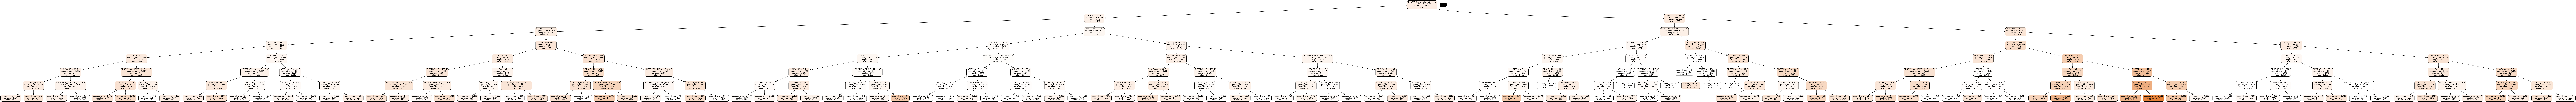

In [53]:
import pydot
from IPython.display import Image

from io import StringIO

dot_data = StringIO()

tree.export_graphviz(tree_clm, out_file = dot_data, proportion = True,
                     feature_names=['DESTINO_LE','ORIGEN_LE', 'PROVINCIA_ORIGEN_LE','PROVINCIA_DESTINO_LE','INTERPROVINCIAL_LE','FESTIVO_LE','SEMANA','MES'], 
                     rounded = True, filled = True)

graph = pydot.graph_from_dot_data(dot_data.getvalue())
Image(graph[0].create_png())

# Random Forest

In [60]:
from sklearn.ensemble import RandomForestRegressor

#1.1 Model Parametrization 
regressor = RandomForestRegressor(n_estimators= 30, max_depth = clm_depth, criterion='absolute_error', random_state=0)
#1.2 Model construction
regressor.fit(X_train_clm, y_train_clm)

# Test
y_pred = regressor.predict(X_test_clm)

# metrics calculation 
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(y_test_clm,y_pred)
print ("Error Measure (MAE) ",  mae)

Error Measure (MAE)  0.7172338755707761


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2822: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if self.run_code(code, result):


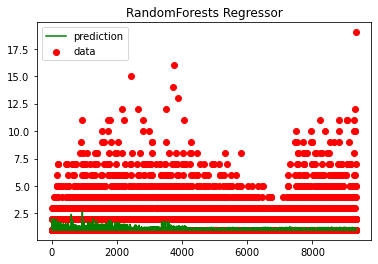

In [64]:
import matplotlib.pyplot as plt
import numpy as np

xx = np.stack(i for i in range(len(y_test_clm
                                   )))
plt.scatter(xx, y_test_clm, c='r', label='data')
plt.plot(xx, y_pred, c='g', label='prediction')
plt.axis('tight')
plt.legend()
plt.title("RandomForests Regressor")

plt.show()

In [65]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn import datasets, ensemble
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_squared_error
rng = np.random.RandomState(1)
# Fit regression model
regressors = []
params = {
    "n_estimators": 500,
    "max_depth": 4,
    "min_samples_split": 5,
    "learning_rate": 0.01,
    "loss": "squared_error",
}

regressors.append(DecisionTreeRegressor(max_depth=clm_depth, criterion='absolute_error'))
# http://scikit-learn.org/stable/auto_examples/ensemble/plot_adaboost_regression.html#
reg = ensemble.GradientBoostingRegressor(**params)
reg.fit(X_train_clm, y_train_clm)
regressors.append(reg)
#regressors.append(AdaBoostRegressor(DecisionTreeRegressor(max_depth=clm_depth, criterion='absolute_error'),
 #                         n_estimators=50, random_state=rng))
#http://scikit-learn.org/stable/auto_examples/ensemble/plot_gradient_boosting_regression.html#sphx-glr-auto-examples-ensemble-plot-gradient-boosting-regression-py                         
regressors.append(GradientBoostingRegressor(n_estimators=100, learning_rate=0.1,
                                   max_depth=clm_depth, random_state=0, loss='squared_error'))

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2822: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if self.run_code(code, result):


Error Measure 0.720622859589041


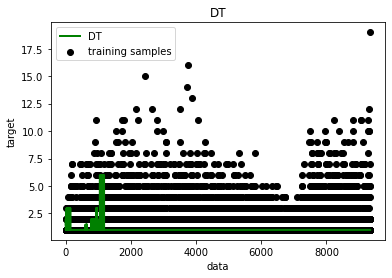

Error Measure 0.7550734013227794


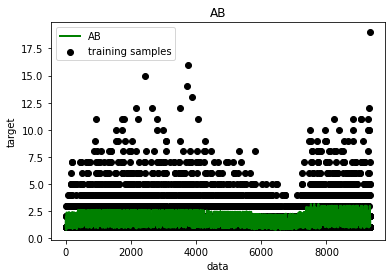

Error Measure 0.734523341305373


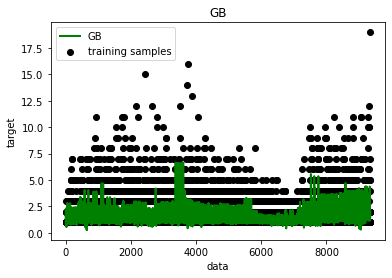

In [66]:

xx = np.stack(i for i in range(len(y_test_clm)))
regr_names = ["DT", "AB", "GB"]
               
for i, r in enumerate(regressors):
    r.fit(X_train_clm, y_train_clm)
    y = r.predict(X_test_clm)
    print ("Error Measure", mean_absolute_error(y_test_clm,y))
    # Plot the results
    plt.figure()
    plt.scatter(xx, y_test_clm, c="k", label="training samples")
    plt.plot(xx, y, c="g", label=regr_names[i], linewidth=2)
    plt.xlabel("data")
    plt.ylabel("target")
    plt.title(regr_names[i])
    plt.axis('tight')
    plt.legend()
    plt.show()
